In [1]:
import sys
sys.path.append("../src")
import os
import re
import json
from itertools import islice
from collections import Counter
from opencc import OpenCC
from tqdm.auto import tqdm
from stanza.server import CoreNLPClient
from stanford_utils import *

In [2]:
os.environ["CORENLP_HOME"] = os.path.expanduser("~/etc/stanford-corenlp-4.4.0")

In [3]:
with open("../data/qsylls_fasttext.csv", "r") as fin:
    qsylls = fin.readlines()

In [4]:
qs_iter = iter(qsylls)
batch_iter = iter(lambda: list(islice(qs_iter, 3)), [])

In [5]:
list(islice(batch_iter, 10))

[['非會員試\n', '平方公里\n', '中華民國\n'],
 ['澳大利亚\n', '社会主义\n', '另一方面\n'],
 ['马来西亚\n', '维基百科\n', '除此之外\n'],
 ['巴基斯坦\n', '与此同时\n', '阿里巴巴\n'],
 ['為輻鰭魚\n', '免費視訊\n', '奥林匹克\n'],
 ['不好意思\n', '绝大多数\n', '哥伦比亚\n'],
 ['翻譯而來\n', '各种各样\n', '也就是说\n'],
 ['黑龙江省\n', '前所未有\n', '第二十一\n'],
 ['共产主义\n', '火影忍者\n', '资本主义\n'],
 ['第二十二\n', '搜尋關鍵\n', '第二十三\n']]

## Simple Cases

## Select NP compounds from four-char words

In [ ]:
qs_iter = iter(qsylls)
batch_size = 10
batch_iter = iter(lambda: list(islice(qs_iter, batch_size)), [])
t2s = OpenCC('t2s.json')

np_compounds = []
with CoreNLPClient(properties="chinese",
        annotators=['tokenize','ssplit','pos','parse'],
        timeout=30000,        
        memory='6G', be_quiet=True) as client:    
    for qs_list in tqdm(batch_iter):
        qs_sen = "。".join(x.strip() for x in qs_list)
        ann = client.annotate(t2s.convert(qs_sen))
        for qs_x, sent_x in zip(qs_list, ann.sentence):
            np_nodes = get_nodes(sent_x.parseTree, is_np_compound)            
            if np_nodes:
                npcs = flatten_compound(np_nodes[0])
                np_compounds.append(npcs)        

In [44]:
len(np_compounds)

42471

In [49]:
with open("../data/fasttext_compounds.csv", "w") as fout:
    for np_x, pos_x in np_compounds:
        if all(len(x)==2 for x in np_x):
            fout.write(f"{','.join(np_x)},{','.join(pos_x)}\n")

with open("../data/fasttext_compounds_nn2.csv", "w") as fout:
    for np_x, pos_x in np_compounds:
        if any(x!="NN" for x in pos_x):
            continue
        if all(len(x)==2 for x in np_x):
            fout.write(f"{','.join(np_x)},{','.join(pos_x)}\n")

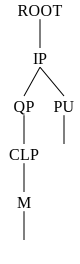

In [39]:
import svgling
svgling.draw_tree(to_linear(ann.sentence[1].parseTree))